In [1]:
import numpy as np
import os
import logging

from standard_tester import *

from runlmc.models.lmc import LMC, _LOG
_LOG.setLevel(logging.INFO)
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
# as chosen in Nguyen 2014
ks = [RBF(name='rbf0')]
ranks = [2]
# the columns with nonzero test holdout are in test_fx
xss, yss, test_xss, test_yss, test_fx, cols = foreign_exchange_2007()

In [3]:
llgp_time, llgp_smse, llgp_nlpd, lmc = runlmc(
    1, None, xss, yss, test_xss, test_yss,
    ks, ranks, {'max_it': 100, 'verbosity': 20})
print('time', llgp_time, 'smse', llgp_smse, 'nlpd', llgp_nlpd)

starting adadelta {'step_rate': 1, 'decay': 0.9, 'momentum': 0.5, 'offset': 0.0001, 'max_it': 100, 'verbosity': 20, 'min_grad_ratio': 0.5, 'roll': 2}
iteration        5 grad norm 2.2796e+02
iteration       10 grad norm 2.6322e+02
iteration       15 grad norm 1.5836e+02
iteration       20 grad norm 2.7646e+02
finished adadelta optimization
            23 iterations
    1.7531e+02 final grad norm
    1.3631e+02 final MA(2) grad norm
    3.3872e+02 max MA(2) grad norm
    norm used inf
time 30.8340192661 smse 0.19330168138 nlpd -3.95136906972


In [ ]:
# Interpolating points != inducing points, but might as well give
# both good settings for a pretty picture.
m = len(lmc.inducing_grid)
cogp_time, cogp_smse, cogp_nlpd, cogp_mu, cogp_var = cogp_fx2007(1, m)
print('m', m, 'time', cogp_time, 'smse', cogp_smse, 'nlpd', cogp_nlpd)

In [4]:
all_xs = np.arange(min(xs.min() for xs in xss), max(xs.max() for xs in xss) + 1)
test_ix = {col: list(cols).index(col) for col in test_fx}

In [5]:
print('matrix-free prediction')
with contexttimer.Timer() as t:
    lmc.DENSE_CUTOFF = 3000
    pred_yss, pred_vss = lmc.predict(test_xss)
    lmc.DENSE_CUTOFF = 10000
print('smse', smse(test_yss, pred_yss, yss),
      'nlpd', nlpd(test_yss, pred_yss, pred_vss),
      'time', t.elapsed)
print('cholesky prediction')
with contexttimer.Timer() as t:
    pred_yss, pred_vss = lmc.predict(test_xss)
print('smse', smse(test_yss, pred_yss, yss),
      'nlpd', nlpd(test_yss, pred_yss, pred_vss),
      'time', t.elapsed)
# Now predict for picture (using cholesky)
pred_xss = [all_xs if col in test_fx else [] for col in cols]
pred_yss, pred_vss = lmc.predict(pred_xss)

matrix-free prediction
Using 80 processors in parallel to precompute predictive variances
smse 0.193496627387 nlpd -3.94975647501 time 59.29334081709385
cholesky prediction
smse 0.19330168138 nlpd -3.95136906972 time 0.29499609768390656


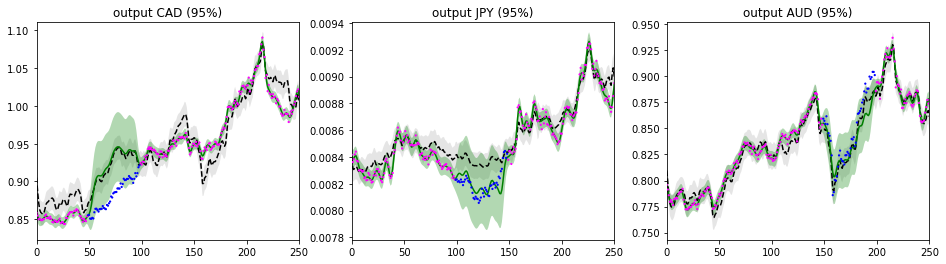

In [6]:
pred_yss = {col: ys for col, ys in zip(cols, pred_yss)}
pred_vss = {col: vs for col, vs in zip(cols, pred_vss)}

_, axs = plt.subplots(ncols=3, figsize=(16, 4))
for col, ax in zip(test_fx, axs):
    
    # Prediction on entire domain for COGP
    ax.plot(all_xs, cogp_mu[col], c='black', ls='--')
    sd = np.sqrt(cogp_var[col])
    top = cogp_mu[col] + 2 * sd
    bot = cogp_mu[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='grey', alpha=0.2)
    
    # Prediction for LLGP
    ax.plot(all_xs, pred_yss[col], c='green')
    sd = np.sqrt(pred_vss[col])
    top = pred_yss[col] + 2 * sd
    bot = pred_yss[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='green', alpha=0.3)    
    
    # Actual holdout
    marker_size = 5
    test_xs = test_xss[test_ix[col]]
    test_ys = test_yss[test_ix[col]]
    ax.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11)
    
    # Rest of image (training)
    rest_xs = xss[test_ix[col]]
    rest_ys = yss[test_ix[col]]
    ax.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10)
        
    ax.set_xlim([0, 250])
    ax.set_title('output {} (95%)'.format(col))


plt.show()

In [7]:
sum(map(len, xss)), sum(map(len, test_xss))

(3054, 150)